In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Generating summary figures for BacSC datasets

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau
import pickle as pkl

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing
### Read data

In [4]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/Sporulation"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")
data_gene_cluster = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

result_path = "../../analysis/B_subt_Rosenthal/Sporulation"
with open(result_path + "_scdeed/scdeed_rel_scores.pkl", "rb") as f:
    rel_scores = pkl.load(f)
with open(result_path + "_scdeed/scdeed_null_rel_scores.pkl", "rb") as f:
    null_rel_scores = pkl.load(f)
with open(result_path + "_scdeed/scdeed_reliabilities.pkl", "rb") as f:
    reliabilities = pkl.load(f)
    
mod_df = pd.read_csv(result_path + "_clustering/modularities.csv")
mod_df_wide = pd.read_csv(result_path + "_clustering/modularities_wide.csv")

data_null_gen = sc.read_h5ad(data_path + "/null_data_opt.h5ad")

figure_path = data_path + "/figures"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

## Single plots
### UMAPs

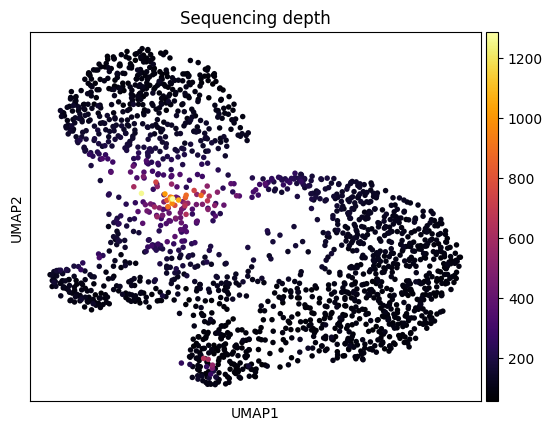

In [5]:
umap_seq_depth = sc.pl.umap(data_gene, color="total_counts", show=False, title="Sequencing depth", cmap="inferno")
plt.savefig(figure_path + "/umap_depth.svg", format="svg")
plt.show()

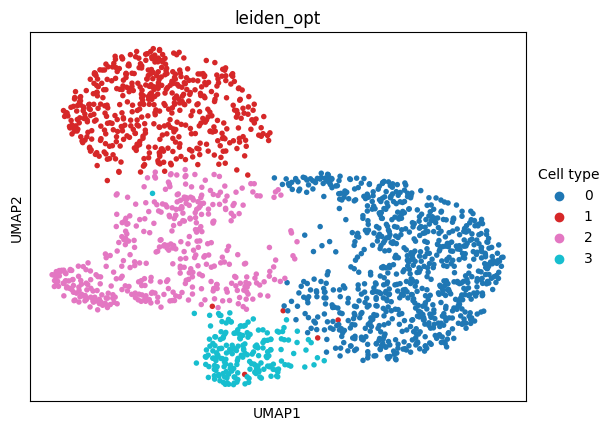

In [6]:
umap_clusters = sc.pl.umap(data_gene, color="leiden_opt", show=False, palette="tab10")
umap_clusters.axes.legend_.set_title("Cell type")
plt.savefig(figure_path + "/umap_clusters.svg", format="svg")
plt.show()

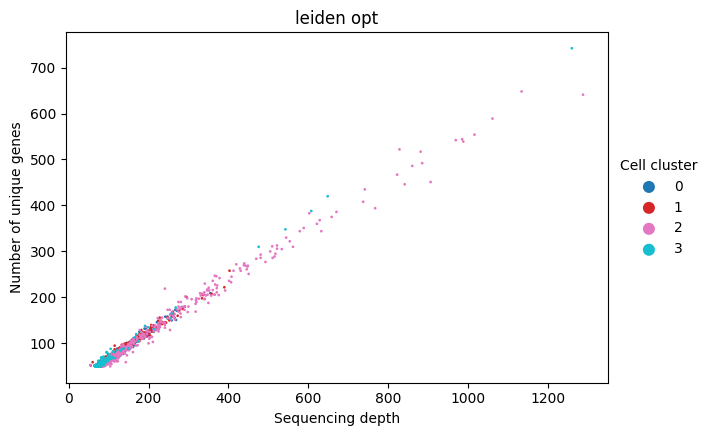

In [7]:
seq_depth_scatter = sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt", palette="tab10")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
seq_depth_scatter.legend_.set_title("Cell cluster")

plt.savefig(figure_path + "/seq_depth_scatter.svg", format="svg")

plt.show()

### Violin plots

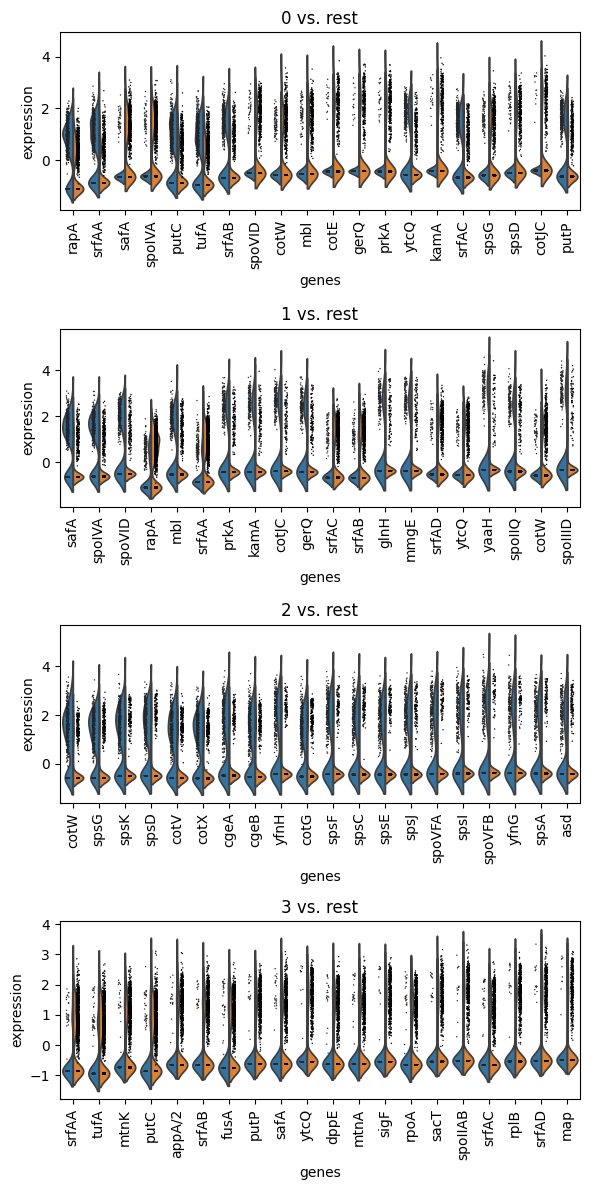

In [8]:
n_genes = 20
clusters = data_gene.obs["leiden_opt"].unique().tolist()
clusters.sort()

fig, ax = plt.subplots(len(clusters), 1, figsize=(6, 3*len(clusters)))

i = 0
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    violins = sc.pl.rank_genes_groups_violin(data_gene_cluster, gene_names=plot_genes, key="ClusterDE_results", groups=c, ax=ax[i], show=False)
    
    i += 1
    
plt.tight_layout()
plt.savefig(figure_path + "/violin_plots.svg", format="svg")

plt.show()

### Heatmap of highly differential genes

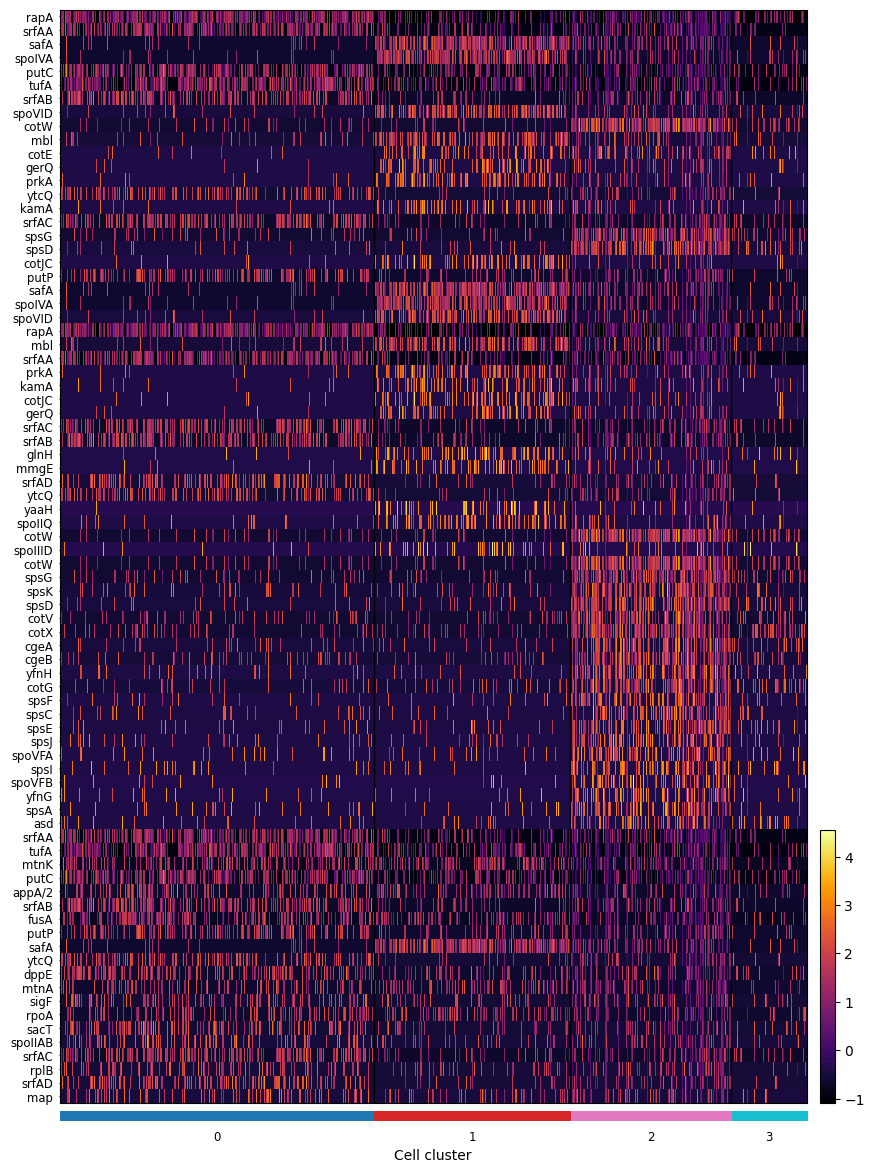

In [9]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes

heatmap_plot = sc.pl.heatmap(data_gene_cluster, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True, show=False, cmap="inferno")
heatmap_plot["groupby_ax"].set(xlabel="Cell cluster")

plt.savefig(figure_path + "/heatmap.svg", format="svg")

plt.show()

In [10]:
print(data_gene.X.shape)
data_gene.obs["leiden_opt"].value_counts()

(1910, 2922)


0    803
1    501
2    411
3    195
Name: leiden_opt, dtype: int64

In [11]:
20/2952

0.006775067750677507

In [12]:
heatmap_plot

{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: xlabel='Cell cluster'>}

### Volcano plots

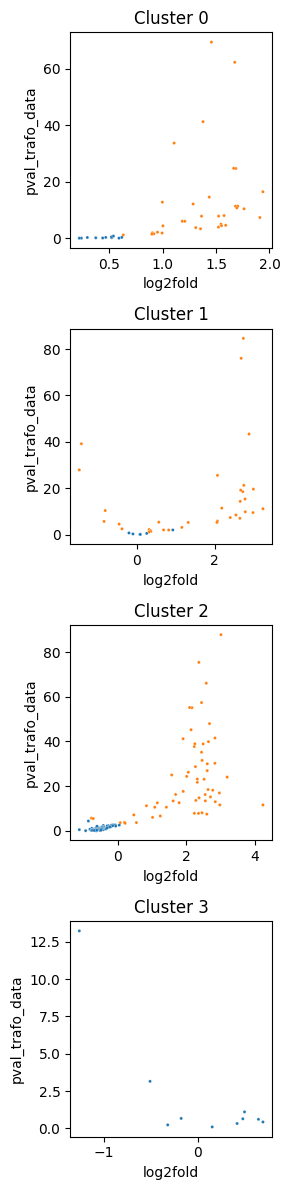

In [16]:
fig, ax = plt.subplots(len(clusters), 1, figsize=(3, 3*len(clusters)))

i=0
for c in clusters:
    pvals_test = data_gene_cluster.uns["ClusterDE_results"][c]

    expr_gene_group_1 = data_gene[data_gene.obs["leiden_opt"] == c].layers["vst_counts"].copy().toarray()
    expr_gene_group_0 = data_gene[data_gene.obs["leiden_opt"] != c].layers["vst_counts"].copy().toarray()

    sum_group_0 = np.log2(np.mean(np.exp(expr_gene_group_0), axis=0) - (data_gene.var["nb_overdisp_cutoff"] / 4) + 1e-9)
    sum_group_1 = np.log2(np.mean(np.exp(expr_gene_group_1), axis=0) - (data_gene.var["nb_overdisp_cutoff"] / 4) + 1e-9)
    lfc = sum_group_1 - sum_group_0
    
    pvals_test["log2fold"] = lfc
    pvals_test["is_de"] = (pvals_test["q"] <= 0.05)
    pvals_test["log_q"] = -np.log10(pvals_test["q"])

    perc_zero_clust = (np.sum(data_gene_cluster[data_gene_cluster.obs["leiden_opt"] == c].layers["counts"].toarray() == 0, axis=0))/(data_gene_cluster[data_gene_cluster.obs["leiden_opt"] == c].shape[0])
    percent_zeros = pd.DataFrame({"perc_zero": perc_zero_clust}, index=data_gene_cluster.var_names)
    pvals_test["percent_zero"] = percent_zeros["perc_zero"]

    sns.scatterplot(pvals_test[pvals_test["percent_zero"] <= 0.8], x="log2fold", y="pval_trafo_data", hue="is_de", alpha=1, s=5, ax=ax[i])
    ax[i].set_title(f"Cluster {c}")
    ax[i].get_legend().remove()
    i += 1
    
plt.tight_layout()

plt.savefig(figure_path + "/volcano_classic.svg", format="svg")

plt.show()


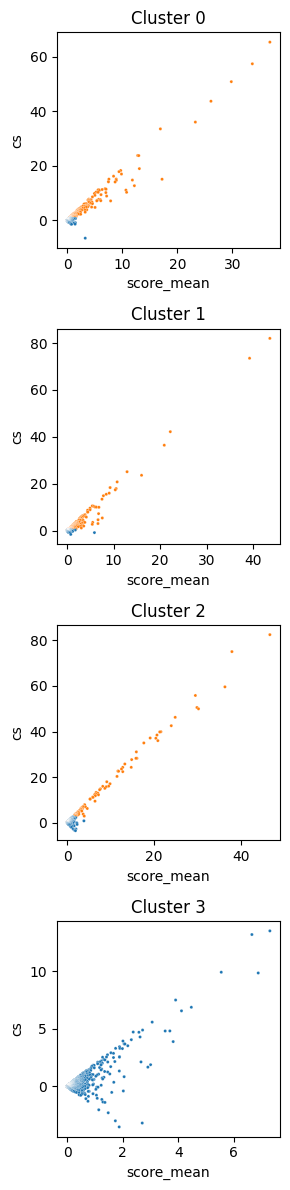

In [17]:
fig, ax = plt.subplots(len(clusters), 1, figsize=(3, 3*len(clusters)))

i = 0
for c in clusters:
    pvals_test = data_gene_cluster.uns["ClusterDE_results"][c]

    pvals_test["score_mean"] = (pvals_test["pval_trafo_data"] + pvals_test["pval_trafo_null"])/2
    pvals_test["is_de"] = (pvals_test["q"] <= 0.05)

    sns.scatterplot(pvals_test, x="score_mean", y="cs", hue="is_de", alpha=1, s=5, ax=ax[i])
    ax[i].set_title(f"Cluster {c}")
    ax[i].get_legend().remove()    
    i += 1

plt.tight_layout()
plt.savefig(figure_path + "/volcano_clusterde.svg", format="svg")

plt.show()

## Combine subplots into one big figure

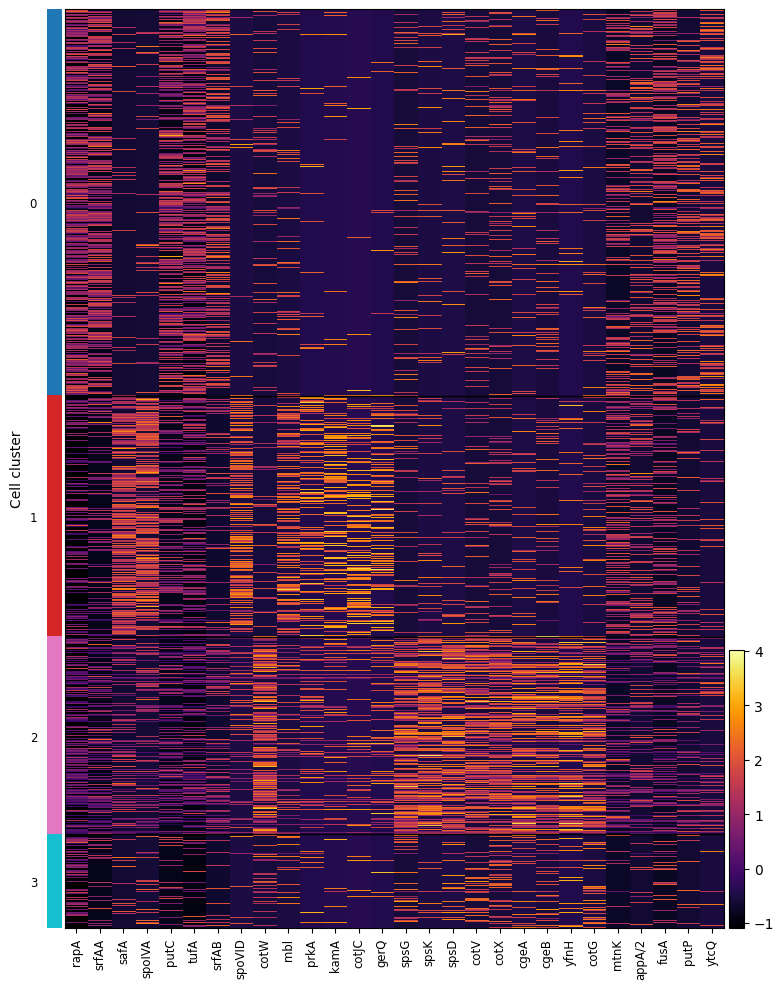

In [18]:
n_genes = 10
clusters = data_gene.obs["leiden_opt"].unique().tolist()
clusters.sort()
n_clusters = len(clusters)

all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    
all_marker_genes = list(dict.fromkeys(all_marker_genes))
heatmap_plot = sc.pl.heatmap(data_gene_cluster, all_marker_genes, groupby='leiden_opt', swap_axes=False, show_gene_labels=True, show=False, cmap="inferno", figsize=(9, 3*n_clusters))
heatmap_plot["groupby_ax"].set(ylabel="Cell cluster")
plt.tight_layout()
plt.savefig(figure_path + "/heatmap_temp3.png", format="png", bbox_inches='tight', dpi=300)

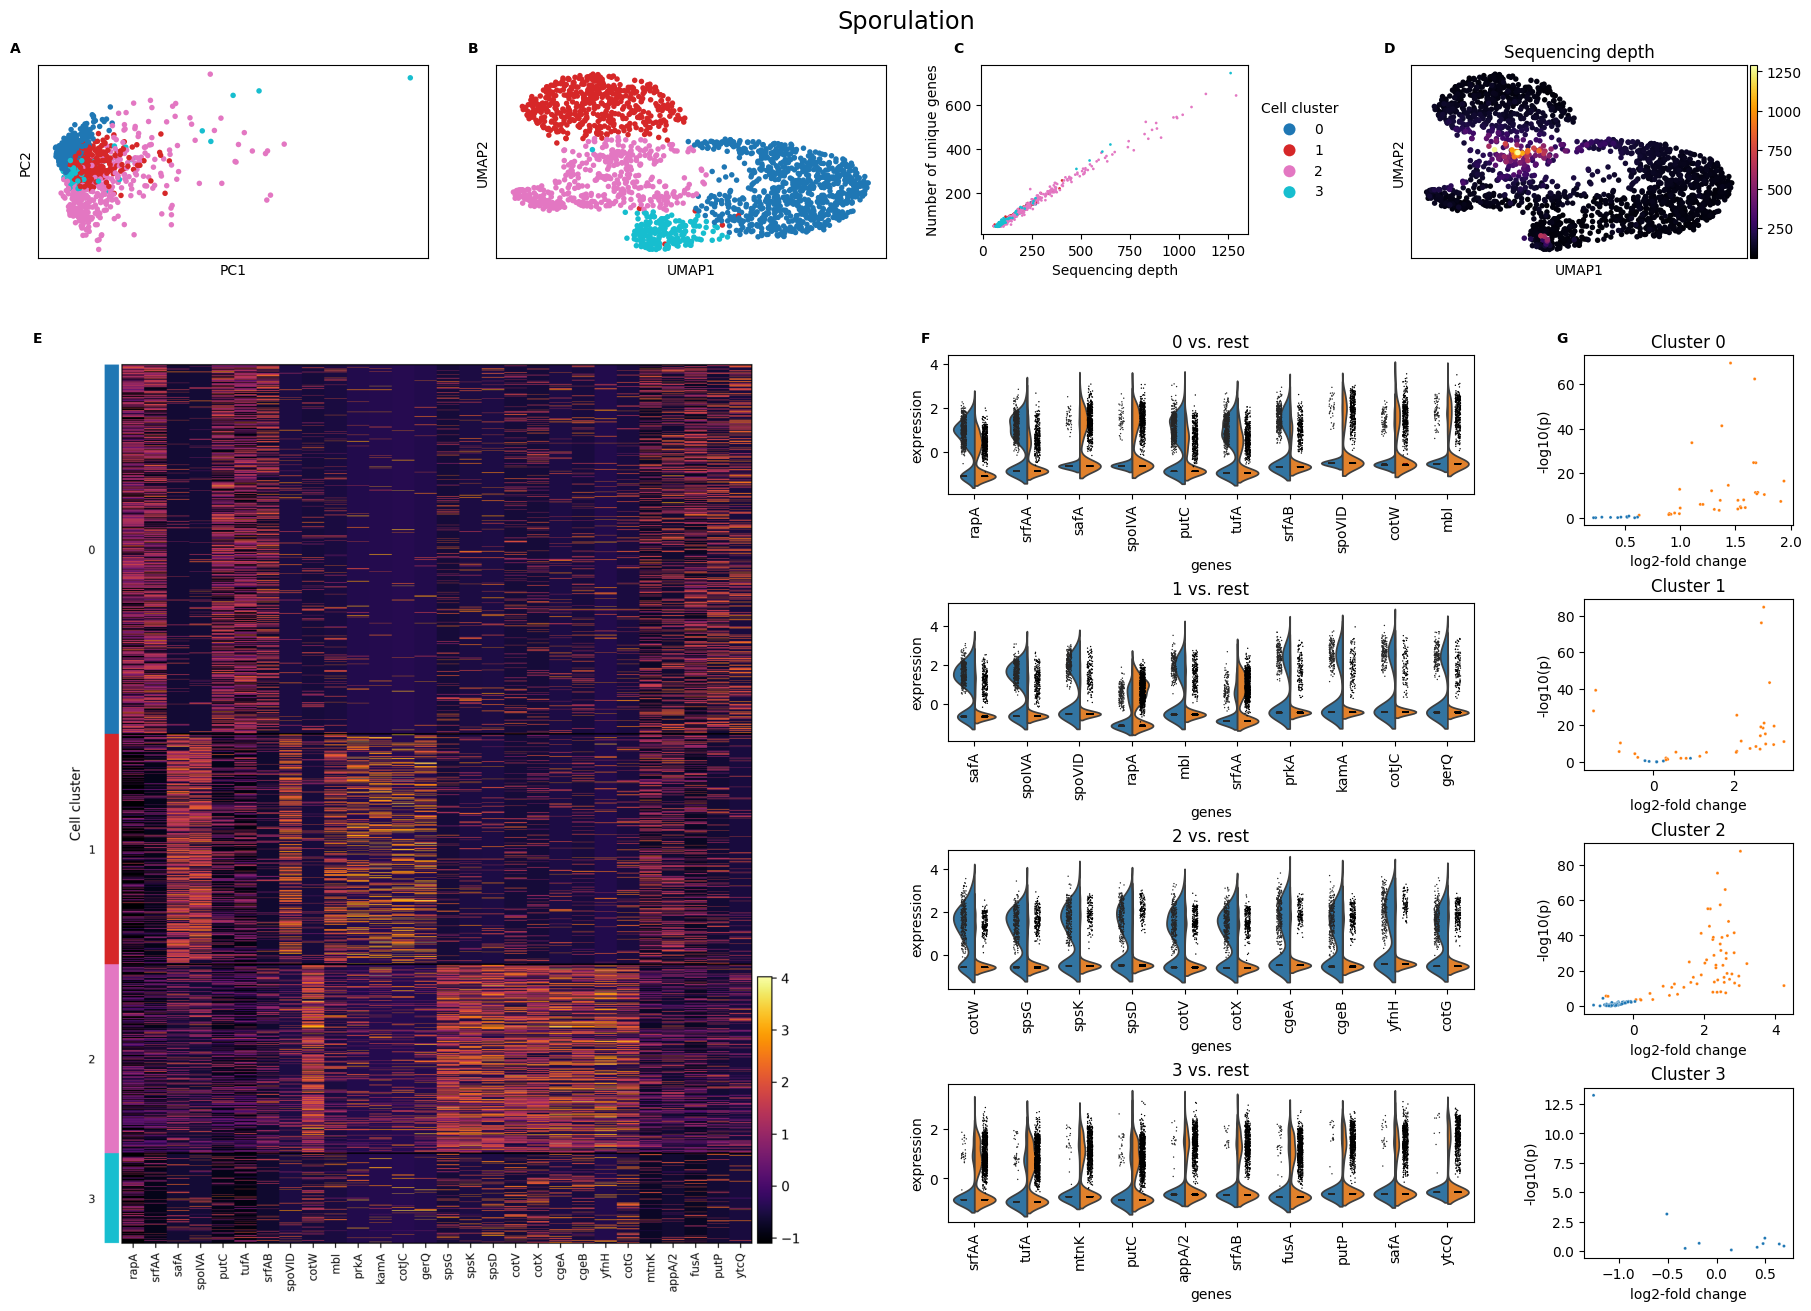

In [19]:
import matplotlib.transforms as mtransforms

# gridspec inside gridspec

fig = plt.figure(layout='constrained', figsize=(18, 3*n_clusters + 1))
subfigs = fig.subfigures(2, 1, hspace=0.07, height_ratios=[1, n_clusters])
subfigsTop = subfigs[0].subfigures(1, 4, wspace=0.07)

ax_pca = subfigsTop[0].subplots(1,1)
sc.pl.pca(data_gene, color="leiden_opt", show=False, ax=ax_pca, title="", legend_loc=None)

ax_umap_cluster = subfigsTop[1].subplots(1,1)
sc.pl.umap(data_gene, color="leiden_opt", show=False, palette="tab10", ax=ax_umap_cluster, title="", legend_loc=None)

ax_scatter = subfigsTop[2].subplots(1,1)
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt", palette="tab10", ax=ax_scatter, title="")
ax_scatter.set(xlabel="Sequencing depth", ylabel="Number of unique genes")
ax_scatter.legend_.set_title("Cell cluster")

ax_umap_seqdepth = subfigsTop[3].subplots(1,1) 
sc.pl.umap(data_gene, color="total_counts", show=False, cmap="inferno", ax=ax_umap_seqdepth, title="Sequencing depth")

subfigsBot = subfigs[1].subfigures(1, 3, wspace=0.07, width_ratios=[0.5, 1/3, 1/6])

all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes

heatmap_ax = subfigsBot[0].subplots(1, 1)

img = mpimg.imread(figure_path + "/heatmap_temp3.png")
heatmap_ax.imshow(img)
heatmap_ax.axis('off')

axs_violin = subfigsBot[1].subplots(n_clusters, 1)

i = 0
for c in clusters:
    plot_genes = data_gene_cluster.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_cluster, gene_names=plot_genes, key="ClusterDE_results", groups=c, ax=axs_violin[i], show=False)
    
    i += 1

    
sc.tl.rank_genes_groups(data_gene_cluster, "leiden_opt", method="wilcoxon", layer="vst_counts")

axs_volcano = subfigsBot[2].subplots(n_clusters, 1)

i=0
for c in clusters:
    pvals_test = data_gene_cluster.uns["ClusterDE_results"][c]

    expr_gene_group_1 = data_gene[data_gene.obs["leiden_opt"] == c].layers["vst_counts"].copy().toarray()
    expr_gene_group_0 = data_gene[data_gene.obs["leiden_opt"] != c].layers["vst_counts"].copy().toarray()

    sum_group_0 = np.log2(np.mean(np.exp(expr_gene_group_0), axis=0) - (data_gene.var["nb_overdisp_cutoff"] / 4) + 1e-9)
    sum_group_1 = np.log2(np.mean(np.exp(expr_gene_group_1), axis=0) - (data_gene.var["nb_overdisp_cutoff"] / 4) + 1e-9)
    lfc = sum_group_1 - sum_group_0
    
    pvals_test["log2fold"] = lfc
    pvals_test["is_de"] = (pvals_test["q"] <= 0.05)

    perc_zero_clust = (np.sum(data_gene_cluster[data_gene_cluster.obs["leiden_opt"] == c].layers["counts"].toarray() == 0, axis=0))/(data_gene_cluster[data_gene_cluster.obs["leiden_opt"] == c].shape[0])
    percent_zeros = pd.DataFrame({"perc_zero": perc_zero_clust}, index=data_gene_cluster.var_names)
    pvals_test["percent_zero"] = percent_zeros["perc_zero"]

    sns.scatterplot(pvals_test[pvals_test["percent_zero"] <= 0.8], x="log2fold", y="pval_trafo_data", hue="is_de", alpha=1, s=5, ax=axs_volcano[i])
    axs_volcano[i].set_title(f"Cluster {c}")
    axs_volcano[i].get_legend().remove()
    axs_volcano[i].set(xlabel="log2-fold change", ylabel="-log10(p)")
    i += 1
    
axes = [ax_pca, ax_umap_cluster, ax_scatter, ax_umap_seqdepth, heatmap_ax, axs_violin, axs_volcano]
labels = ["A", "B", "C", "D", "E", "F", "G"]

for ax, label in zip(axes, labels):
    if type(ax) == np.ndarray:
        ax = ax[0]
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontweight="bold")

fig.suptitle('Sporulation', fontsize='xx-large')
plt.savefig(figure_path + "/summary_figure.svg", format="svg")

plt.show()

## Technical summary figure

### scTransform Theta parameters

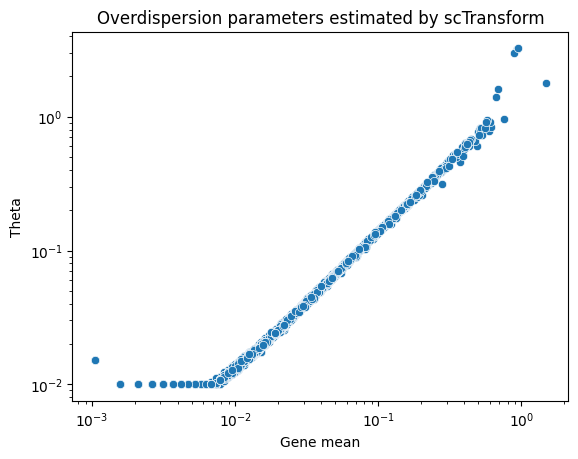

In [20]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

### Sequencing depth distribution before and after VST

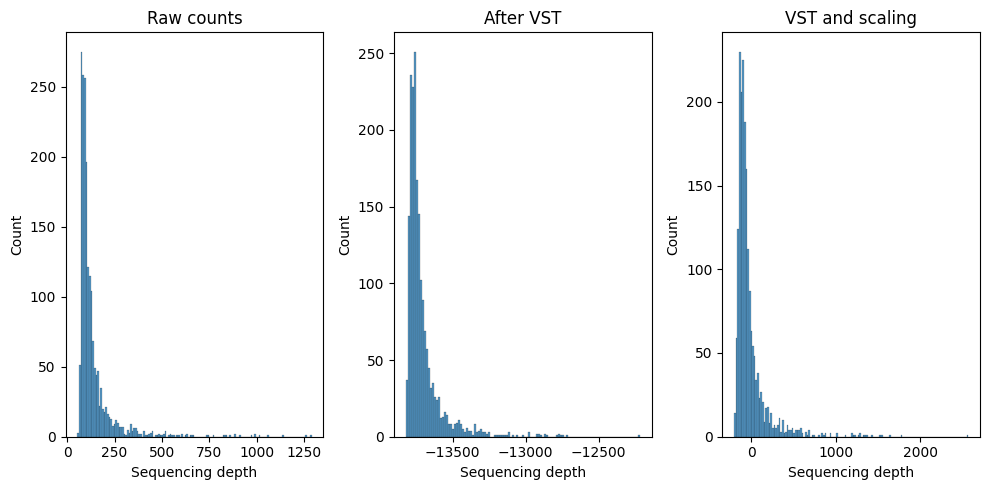

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Raw counts")
axes[0].set(xlabel="Sequencing depth")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("After VST")
axes[1].set(xlabel="Sequencing depth")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaling")
axes[2].set(xlabel="Sequencing depth")
plt.tight_layout()
plt.show()

### Latent dimensionality

In [22]:
k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

In [23]:
is_overdispersed = False
data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)

# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")



Optimal number of PCs:4


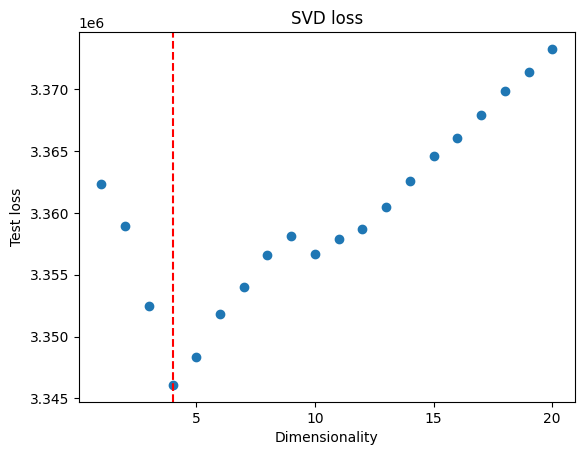

In [24]:
fig, ax = plt.subplots()
ax.scatter(np.arange(20) + 1, k_errors)
ax.set_title("SVD loss")
ax.set(xlabel="Dimensionality", ylabel="Test loss")
ax.set_xticks([5, 10, 15, 20])
plt.axvline(x=k_opt, color="red", linestyle="dashed")
plt.show()

### scDEED results

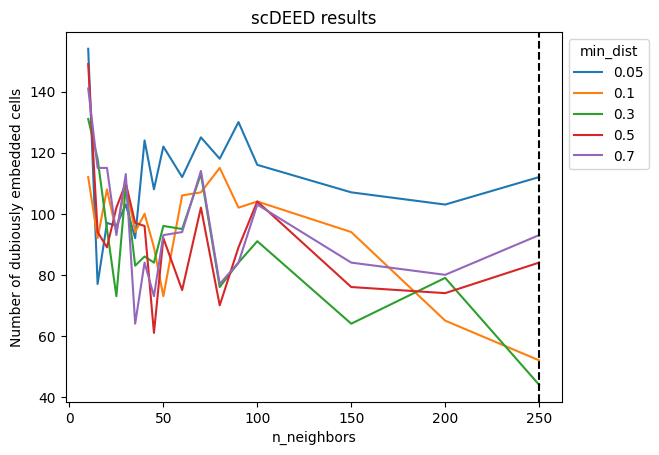

In [25]:
param_df = pd.DataFrame({
    "n_neighbors": [x[0] for x in rel_scores.keys()],
    "min_dist": [x[1] for x in rel_scores.keys()],
    "mean_rel": [np.mean(x) for x in rel_scores.values()],
    "mean_null_rel": [np.mean(x) for x in null_rel_scores.values()],
    "num_dubious": [np.sum([y == "dubious" for y in x]) for x in reliabilities.values()],
    "num_trustworthy": [np.sum([y == "trustworthy" for y in x]) for x in reliabilities.values()],

})
n, p = data_gene.X.shape

param_df["share_dubious"] = param_df["num_dubious"] / n
param_df["share_trustworthy"] = param_df["num_trustworthy"] / n

fig, ax = plt.subplots()
sns.lineplot(data=param_df, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10", ax=ax)
ax.set(title="scDEED results", ylabel="Number of dubiously embedded cells")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_title("min_dist")
plt.axvline(x=n_neighbors_opt, color="black", linestyle="dashed")
plt.show()

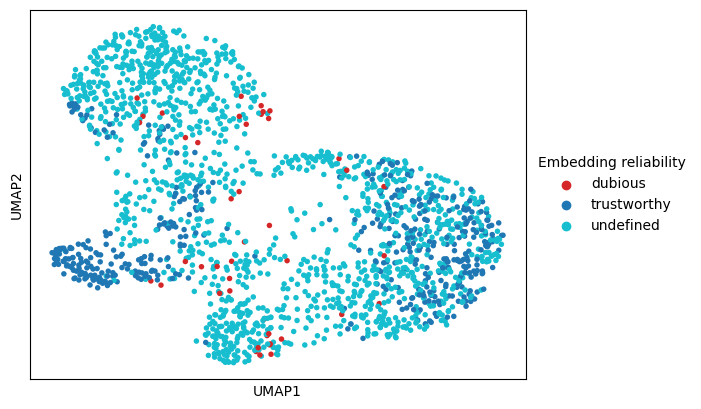

In [26]:
umap_reliability = sc.pl.umap(data_gene, color="embedding_reliability", alpha=1, title="", show=False, 
                              palette={"undefined": "tab:cyan", "trustworthy": "tab:blue", "dubious": "tab:red"}
                             )
umap_reliability.axes.legend_.set_title("Embedding reliability")
plt.show()

### Clustering resolution

In [27]:
mod_df

,Unnamed: 0,resolution,n_clusters,type,score
0,0,0.01,1,train,0.490000
1,1,0.01,1,test,0.490000
2,2,0.01,1,random,0.490000
3,3,0.03,1,train,0.470000
4,4,0.03,1,test,0.470000
...,...,...,...,...,...
70,70,0.47,4,test,0.207911
71,71,0.47,4,random,0.008149
72,72,0.49,4,train,0.241521
73,73,0.49,4,test,0.202752


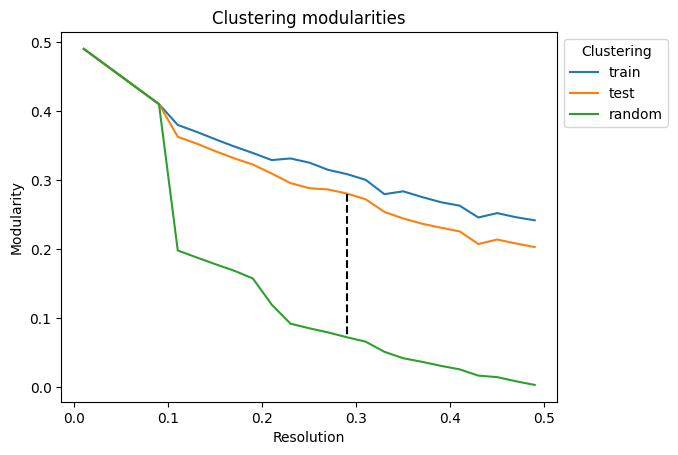

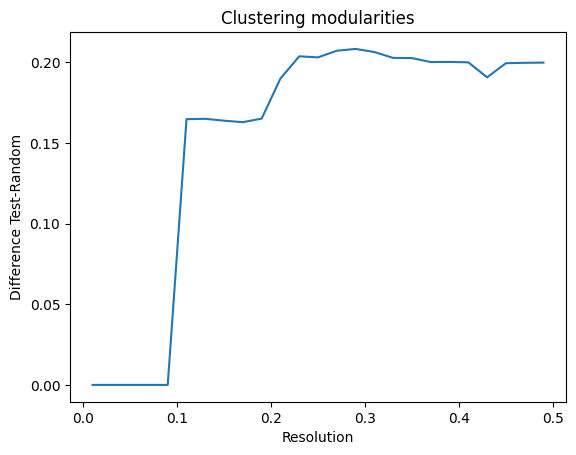

In [28]:
fig, ax = plt.subplots()
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type", ax=ax)
ax.set(title="Clustering modularities", xlabel="Resolution", ylabel="Modularity")
ax.plot(
    [res_opt, res_opt], 
    [mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "test")]["score"],
      mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "random")]["score"]],
    linestyle="dashed", color="black"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_title("Clustering")
plt.show()

sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

### Combine plots

In [29]:
data_null_gen.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,leiden_0,leiden_best
0,58,4.077537,72.0,4.290459,0,0
1,102,4.634729,171.0,5.147494,1,1
2,71,4.276666,117.0,4.770685,1,1
3,74,4.317488,104.0,4.653960,1,1
4,98,4.595120,137.0,4.927254,1,1
...,...,...,...,...,...,...
3815,71,4.276666,95.0,4.564348,1,1
3816,110,4.709530,168.0,5.129899,0,0
3817,76,4.343805,116.0,4.762174,1,1
3818,112,4.727388,164.0,5.105945,0,0


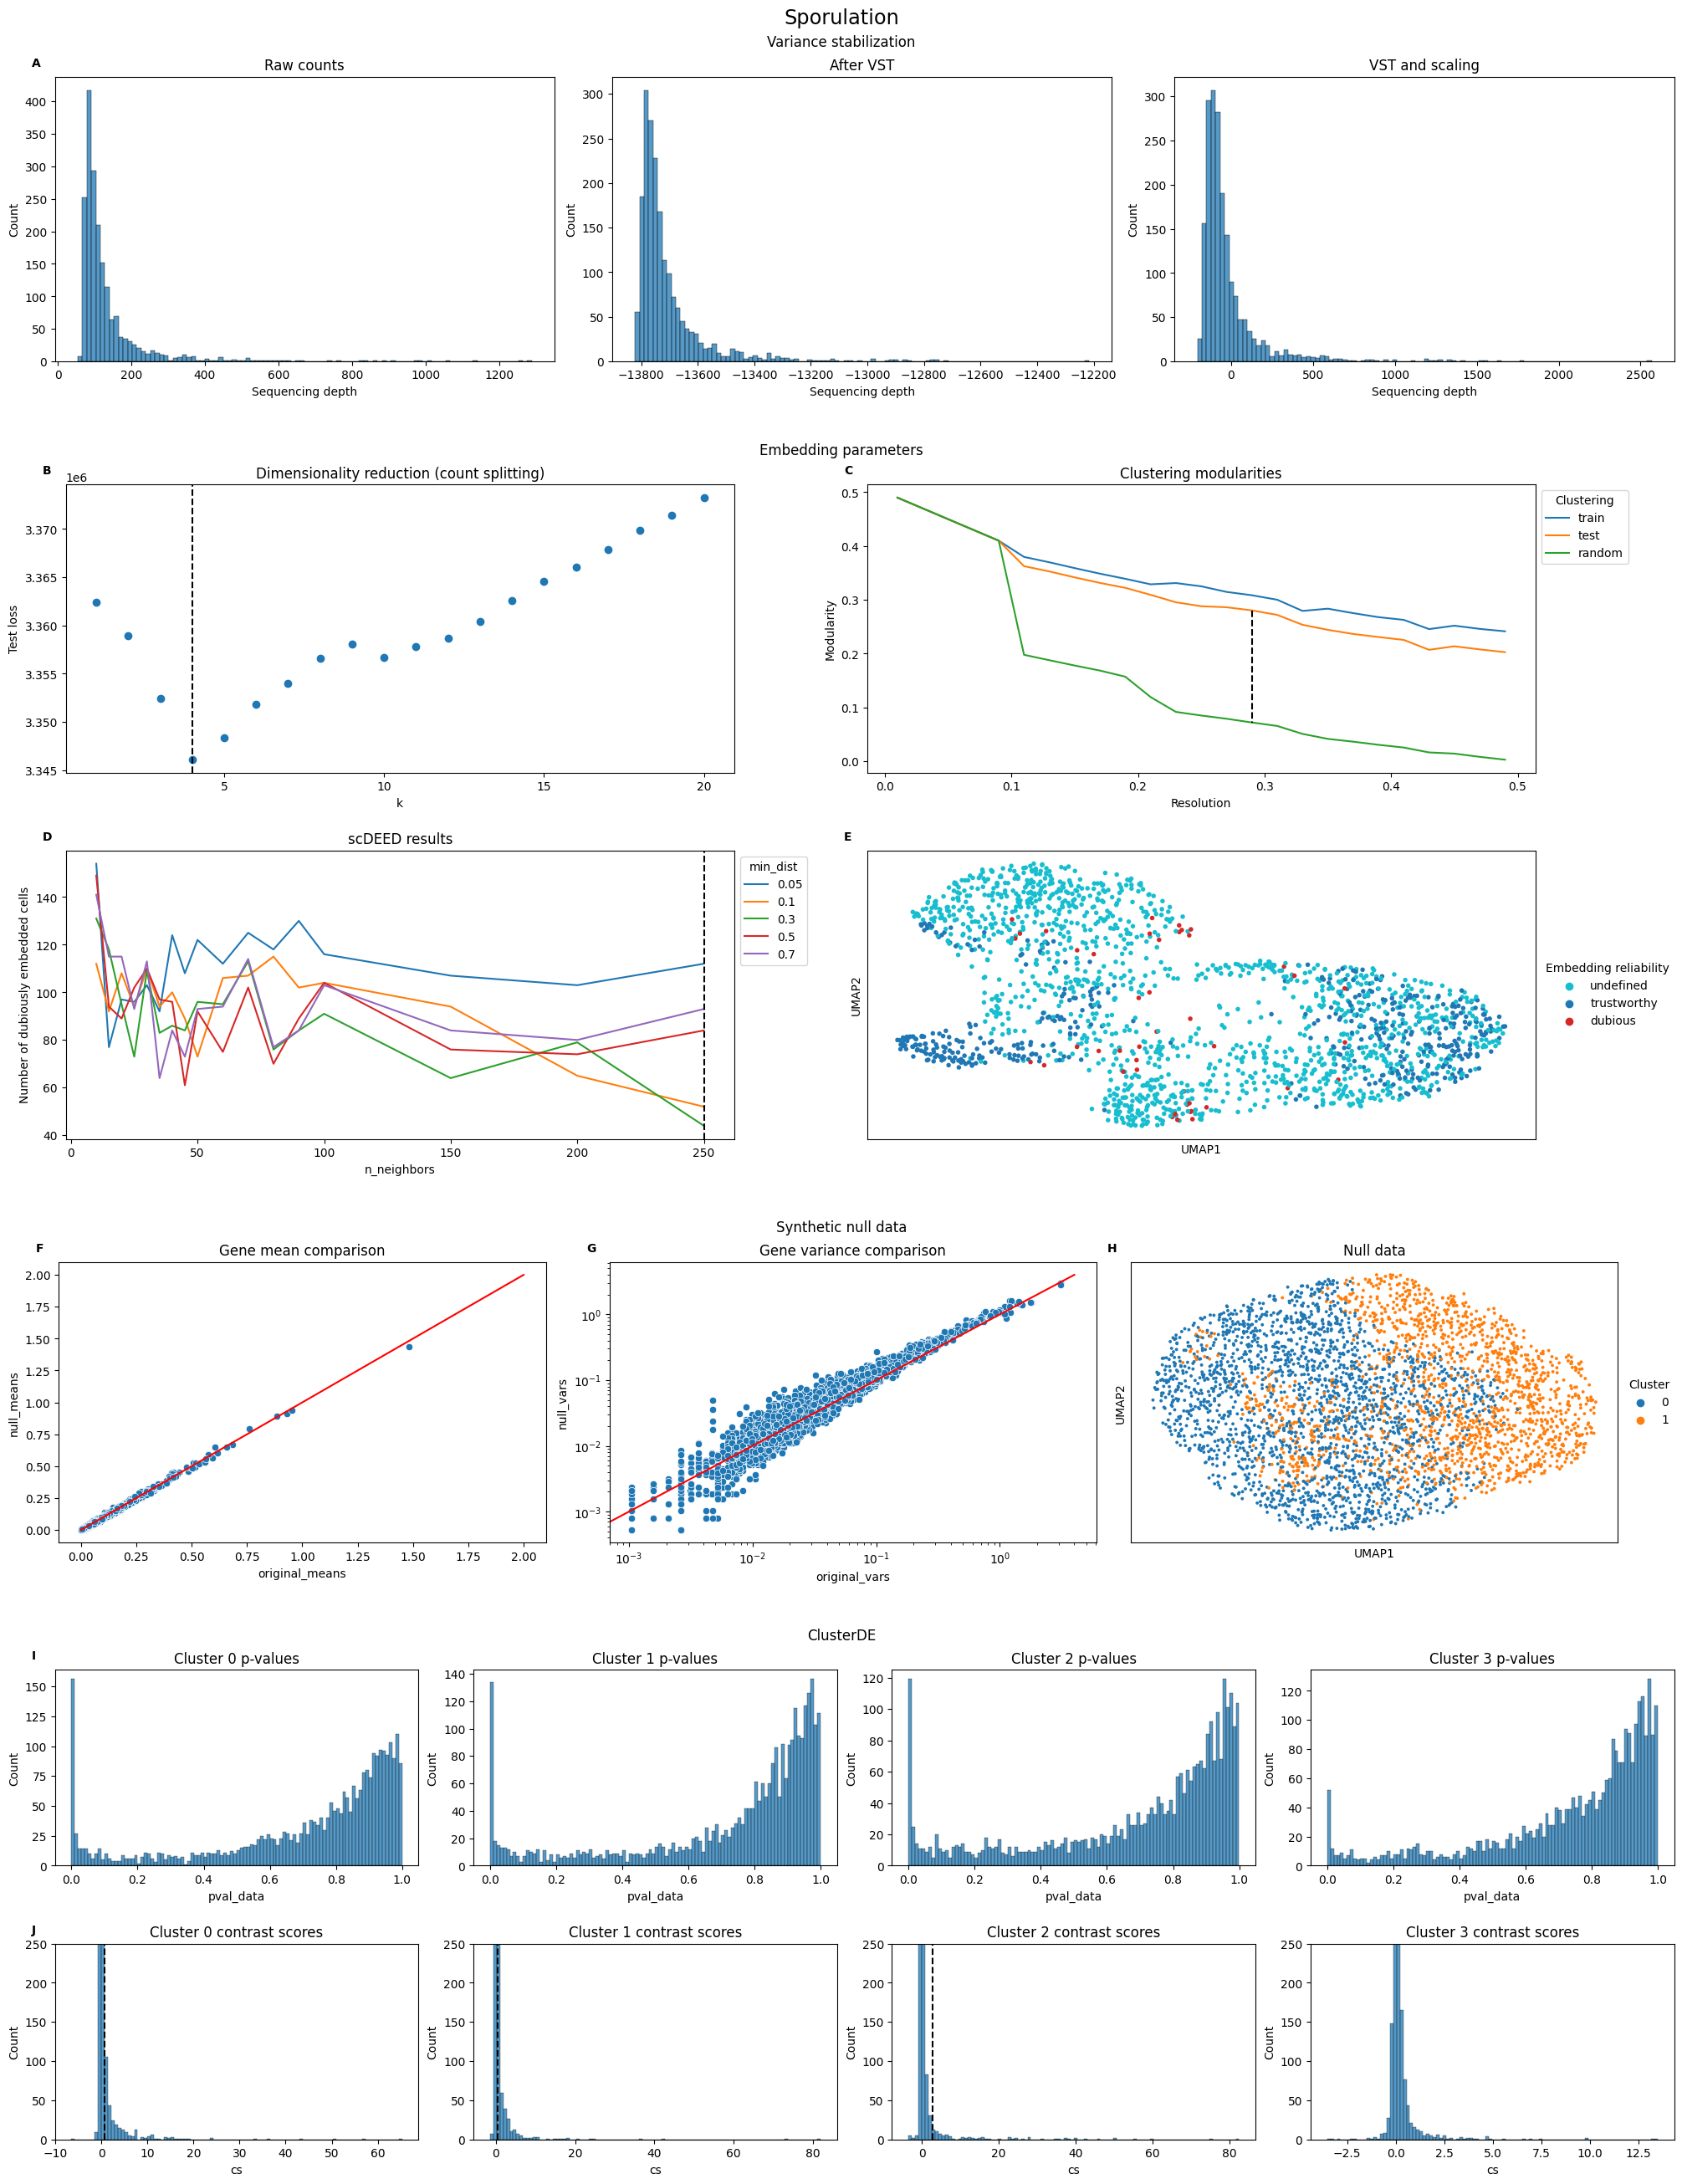

In [30]:
fig = plt.figure(layout='constrained', figsize=(20, 26))
subfigs = fig.subfigures(4, 1, hspace=0.07, height_ratios=[1, 2, 1, 1.5])

subfigs_vst = subfigs[0].subplots(1, 3)

p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=subfigs_vst[0], multiple="stack", bins=100)
subfigs_vst[0].set_title("Raw counts")
subfigs_vst[0].set(xlabel="Sequencing depth")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=subfigs_vst[1], multiple="stack", bins=100)
subfigs_vst[1].set_title("After VST")
subfigs_vst[1].set(xlabel="Sequencing depth")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=subfigs_vst[2], multiple="stack", bins=100)
subfigs_vst[2].set_title("VST and scaling")
subfigs_vst[2].set(xlabel="Sequencing depth")

subfigs[0].suptitle("Variance stabilization")

subfigs_params = subfigs[1].subplots(2,2)

subfigs_params[0,0].scatter(np.arange(20) + 1, k_errors)
subfigs_params[0,0].set_title("Dimensionality reduction (count splitting)")
subfigs_params[0,0].set(xlabel="k", ylabel="Test loss")
subfigs_params[0,0].set_xticks([5, 10, 15, 20])
subfigs_params[0,0].axvline(x=k_opt, color="black", linestyle="dashed")

sns.lineplot(data=param_df, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10", ax=subfigs_params[1,0])
subfigs_params[1,0].set(title="scDEED results", ylabel="Number of dubiously embedded cells")
sns.move_legend(subfigs_params[1,0], "upper left", bbox_to_anchor=(1, 1))
subfigs_params[1,0].legend_.set_title("min_dist")
subfigs_params[1,0].axvline(x=n_neighbors_opt, color="black", linestyle="dashed")

data_gene.obs["embedding_reliability"] = data_gene.obs["embedding_reliability"].cat.reorder_categories(['undefined', 'trustworthy', 'dubious'])
cmap = {"undefined": "tab:cyan", "trustworthy": "tab:blue", "dubious": "tab:red"}
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1, title="", show=False, ax=subfigs_params[1,1], palette=cmap)
subfigs_params[1,1].legend_.set_title("Embedding reliability")

sns.lineplot(data=mod_df, x="resolution", y="score", hue="type", ax=subfigs_params[0,1])
subfigs_params[0,1].set(title="Clustering modularities", xlabel="Resolution", ylabel="Modularity")
subfigs_params[0,1].plot(
    [res_opt, res_opt], 
    [mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "test")]["score"],
      mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "random")]["score"]],
    linestyle="dashed", color="black"
)
sns.move_legend(subfigs_params[0,1], "upper left", bbox_to_anchor=(1, 1))
subfigs_params[0,1].legend_.set_title("Clustering")

subfigs[1].suptitle("Embedding parameters")

subfigs_null_data = subfigs[2].subplots(1, 3)

mean_df_opt = pd.DataFrame({"original_means": data_gene_cluster.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=subfigs_null_data[0])
subfigs_null_data[0].plot([0, np.ceil(np.max(data_gene_cluster.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_cluster.var["mean_counts"]))], color="red")
subfigs_null_data[0].set_title("Gene mean comparison")

var_df_opt = pd.DataFrame({"original_vars": data_gene_cluster.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=subfigs_null_data[1])
g.set(xscale="log", yscale="log")
subfigs_null_data[1].plot([0, np.ceil(np.max(data_gene_cluster.var["var_counts"]))], [0, np.ceil(np.max(data_gene_cluster.var["var_counts"]))], color="red")
subfigs_null_data[1].set_title("Gene variance comparison")

sc.pl.umap(data_null_gen, color="leiden_best", alpha=1, title="Null data", show=False, ax=subfigs_null_data[2])
subfigs_null_data[2].legend_.set_title("Cluster")

subfigs[2].suptitle("Synthetic null data")

pvals_log_gen = data_gene_cluster.uns["ClusterDE_results"]
clusters = data_gene_cluster.obs["leiden_opt"].unique().tolist()
clusters.sort()
n_clusters = len(clusters)
subfigs_clusterde = subfigs[3].subplots(2, n_clusters)

i = 0
for c in clusters:
    sns.histplot(pvals_log_gen[c], x="pval_data", ax=subfigs_clusterde[0,i], bins=100)
    subfigs_clusterde[0,i].set_title(f"Cluster {c} p-values")
    
    sns.histplot(pvals_log_gen[c], x="cs", ax=subfigs_clusterde[1,i], bins=100)
    subfigs_clusterde[1,i].set_title(f"Cluster {c} contrast scores")
    subfigs_clusterde[1,i].set(ylim=(0, 250))
    if np.min(pvals_log_gen[c]["q"]) <= 0.05:
        cutoff = np.min(pvals_log_gen[c][pvals_log_gen[c]["q"] <= 0.05]["cs"])
        subfigs_clusterde[1,i].axvline(x=cutoff, color="black", linestyle="dashed")
    
    i += 1
    
subfigs[3].suptitle("ClusterDE")

axes = [subfigs_vst, subfigs_params[0,0], subfigs_params[0,1], subfigs_params[1,0], subfigs_params[1,1], subfigs_null_data[0], subfigs_null_data[1], subfigs_null_data[2], subfigs_clusterde[0,0], subfigs_clusterde[1,0]]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]

for ax, label in zip(axes, labels):
    if type(ax) == np.ndarray:
        ax = ax[0]
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontweight="bold")

fig.suptitle('Sporulation', fontsize='xx-large')
plt.savefig(figure_path + "/technical_figure.svg", format="svg")
plt.show()

In [31]:
print(data_gene.obs["embedding_reliability"])

AAACCCACATGTCAGT-1    trustworthy
AAACCCAGTGAGTGAC-1      undefined
AAACCCAGTGGTTTAC-1    trustworthy
AAACGAAGTAGACGGT-1      undefined
AAACGCTTCGACACCG-1    trustworthy
                         ...     
TTTGGTTCACGCGGTT-1      undefined
TTTGTTGAGGGTGAAA-1      undefined
TTTGTTGGTAGGACTG-1      undefined
TTTGTTGTCAAACCCA-1      undefined
TTTGTTGTCCCTCTCC-1      undefined
Name: embedding_reliability, Length: 1910, dtype: category
Categories (3, object): ['undefined', 'trustworthy', 'dubious']
